## Knowledge about the dataset

As a part of the Cool Neighborhoods Initiative, the NYC Parks Department, Mayor’s Office of Resilience and NYC Department of Health and Mental Hygiene monitored street level temperature on a subset of city blocks in some of the neighborhoods with highest heat mortality risk during June-September of 2018 and 2019.  
The dataset includes hourly average values at approximately 475 locations in degrees Farenheit.  These data help to understand what characteristics of a block make it hotter or cooler than other blocks and will allow for comparison of  temperatures measured following the planting and growth of street trees, also part of the Cool Neighborhoods Initiative. 
HOBO TidbiT® v2 loggers were mounted facing north and 1.5-2.5m above the ground on street trees (under canopy)  and light poles (no canopy)  in 16 medium to high HVI neighborhoods with approximately 35 sensors each within a 1km2 cell. The loggers were covered with the TidbiT® white boot and attached on white backplate. 
The white boot and backplate reduce the effect of direct sunlight on the sensor to some extent but we caution users that temperatures from 12 noon to 6 PM should not be used due to inconsistent shading of the sensors. Each record in this dataset represents an hourly average of observations taken at 10 minute intervals along with date, location and other descriptors. 

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [44]:
# Load dataset (update filename if needed)
df = pd.read_csv("Hyperlocal_Temperature_Monitoring_20250130.csv")

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097150 entries, 0 to 2097149
Data columns (total 10 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Sensor.ID     object 
 1   AirTemp       float64
 2   Day           object 
 3   Hour          int64  
 4   Latitude      float64
 5   Longitude     float64
 6   Year          int64  
 7   Install.Type  object 
 8   Borough       object 
 9   ntacode       object 
dtypes: float64(3), int64(2), object(5)
memory usage: 160.0+ MB


In [46]:
df.head(3)

,Sensor.ID,AirTemp,Day,Hour,Latitude,Longitude,Year,Install.Type,Borough,ntacode
0,Bk-BR_01,71.189000,06/15/2018,1,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81
1,Bk-BR_01,70.243333,06/15/2018,2,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81
2,Bk-BR_01,69.392667,06/15/2018,3,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81


In [47]:
df.value_counts("Install.Type")

Install.Type
Street Tree    1493723
Light Pole      603427
Name: count, dtype: int64

In [48]:
df.value_counts("Borough")

Borough
Brooklyn     857868
Bronx        669196
Manhattan    418616
Queens       151470
Name: count, dtype: int64

In [49]:
# Convert date and hour columns to datetime
df['Datetime'] = pd.to_datetime(df['Day'] + ' ' + df['Hour'].astype(str) + ':00:00')

df.tail(5)

,Sensor.ID,AirTemp,Day,Hour,Latitude,Longitude,Year,Install.Type,Borough,ntacode,Datetime
0,Bk-BR_01,71.189000,06/15/2018,1,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81,2018-06-15 01:00:00
1,Bk-BR_01,70.243333,06/15/2018,2,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81,2018-06-15 02:00:00
2,Bk-BR_01,69.392667,06/15/2018,3,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81,2018-06-15 03:00:00
3,Bk-BR_01,68.263167,06/15/2018,4,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81,2018-06-15 04:00:00
4,Bk-BR_01,67.114000,06/15/2018,5,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81,2018-06-15 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...
2097145,Q-CH_26,78.346667,09/07/2019,15,40.699578,-73.73876,2019,Light Pole,Queens,QN33,2019-09-07 15:00:00
2097146,Q-CH_26,79.517167,09/07/2019,16,40.699578,-73.73876,2019,Light Pole,Queens,QN33,2019-09-07 16:00:00
2097147,Q-CH_26,77.203667,09/07/2019,17,40.699578,-73.73876,2019,Light Pole,Queens,QN33,2019-09-07 17:00:00
2097148,Q-CH_26,75.696000,09/07/2019,18,40.699578,-73.73876,2019,Light Pole,Queens,QN33,2019-09-07 18:00:00


Temperature Variation by Borough:
     Borough     min         max       mean       std
0      Bronx  46.031  114.963667  76.145973  9.339190
1   Brooklyn  46.031  111.546500  75.896338  8.822143
2  Manhattan  46.031  113.156833  76.143061  8.849687
3     Queens  46.031  108.244333  75.289583  8.808966


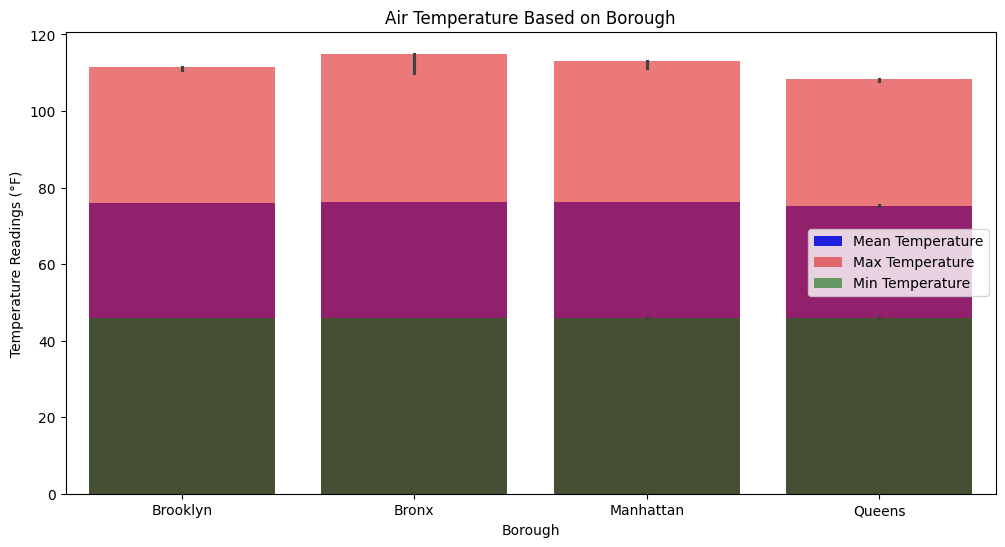

In [50]:
# Bar chart of Air Temperature based on Borough 
Borough_variation = df.groupby('Borough')['AirTemp'].agg(['min', 'max', 'mean', 'std']).reset_index()
print("Temperature Variation by Borough:")
print(Borough_variation.head())

plt.figure(figsize=(12, 6))
sns.barplot(x='Borough', y='AirTemp', data=df, estimator="mean", color='blue', label='Mean Temperature')
sns.barplot(x='Borough', y='AirTemp', data=df, estimator=max, color='red', alpha=0.6, label='Max Temperature')
sns.barplot(x='Borough', y='AirTemp', data=df, estimator=min, color='green', alpha=0.6, label='Min Temperature')

plt.xlabel("Borough")
plt.ylabel("Temperature Readings (°F)")
plt.title("Air Temperature Based on Borough")
plt.legend()
plt.show()


The towns considered approximately had similar temperature experience during the period of the survey. However, the Bronx experiences the highest temperature of $114^0F$ among the other cities considered. 

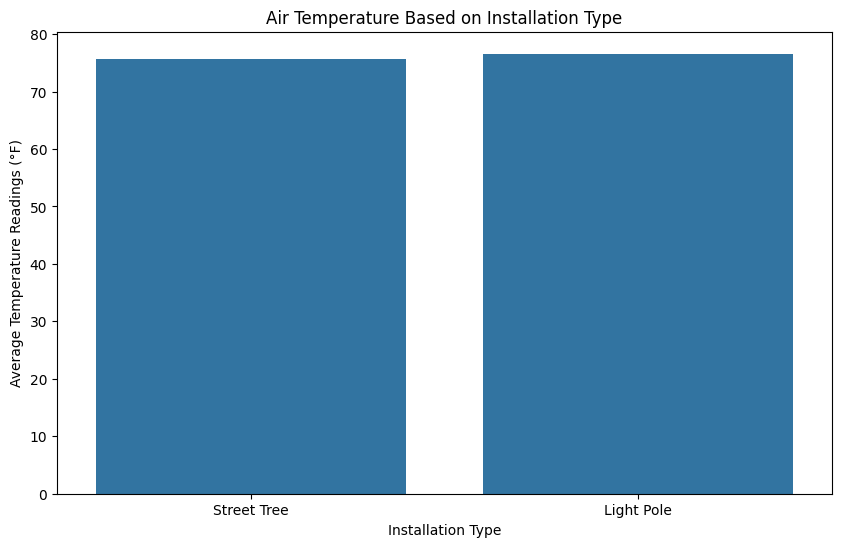

In [52]:
# Bar chart of Air Temperature based on Install Type
plt.figure(figsize=(10, 6))
sns.barplot(x='Install.Type', y='AirTemp', data=df, estimator= "mean")
plt.xlabel("Installation Type")
plt.ylabel("Average Temperature Readings (°F)")
plt.title("Air Temperature Based on Installation Type")
plt.show()

Temperature Variation by Neighborhood:
  ntacode        min         max       mean       std
0    BK33  46.338500  105.478000  75.743007  8.813279
1    BK35  46.263500  109.966500  75.889017  8.553669
2    BK37  46.211000  111.546500  76.225172  9.331235
3    BK60  46.405667  109.126667  76.501753  8.980650
4    BK61  46.196000  109.986333  75.775186  8.722592


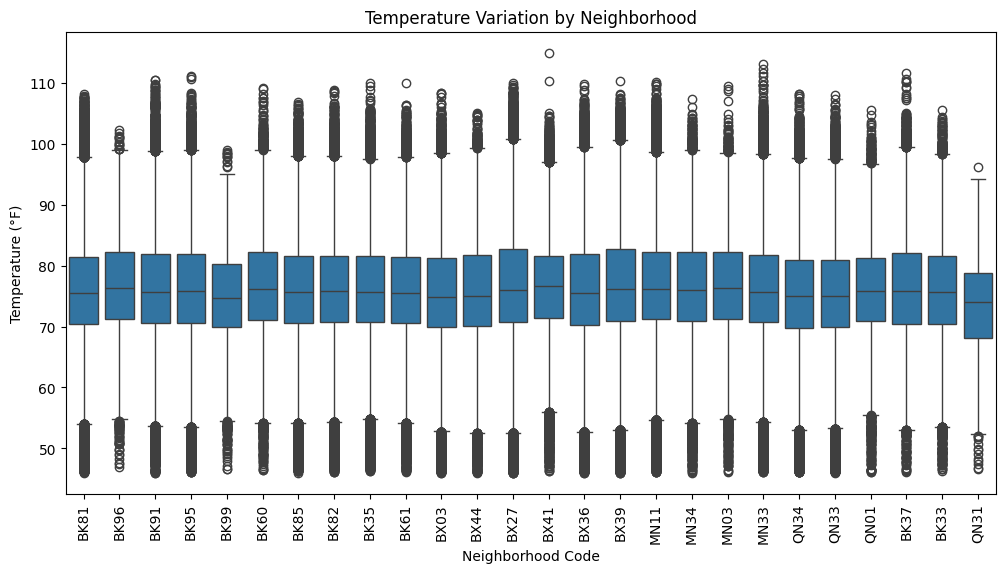

In [53]:
# Temperature variation within a neighborhood
neighborhood_variation = df.groupby('ntacode')['AirTemp'].agg(['min', 'max', 'mean', 'std']).reset_index()
print("Temperature Variation by Neighborhood:")
print(neighborhood_variation.head())
    
plt.figure(figsize=(12, 6))
sns.boxplot(x='ntacode', y='AirTemp', data=df)
plt.xticks(rotation=90)
plt.xlabel("Neighborhood Code")
plt.ylabel("Temperature (°F)")
plt.title("Temperature Variation by Neighborhood")
plt.show()

The descriptive statistic and the boxplot show that the temperature values across the neighborhoods differ minimally significantly. This implies that the neighboring communities have had similar experiences in their temperature variation over the years 2018 and 2019.

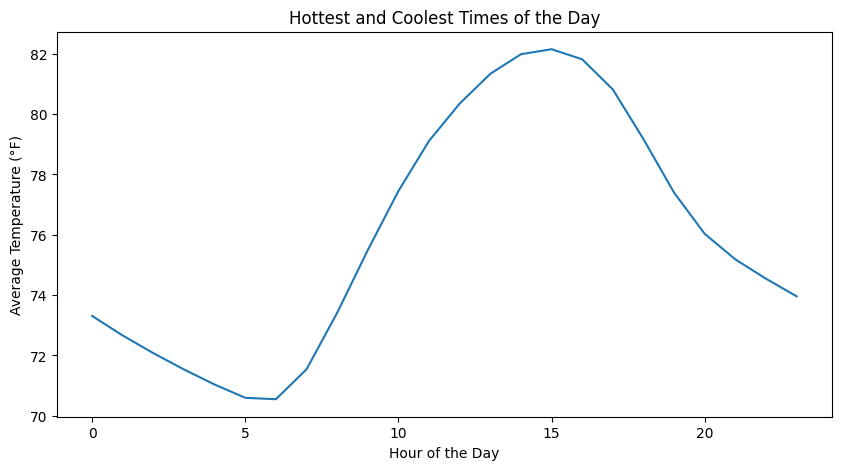

In [55]:
#Hottest and coolest times of the day
hourly_avg = df.groupby('Hour')['AirTemp'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values)
plt.xlabel("Hour of the Day")
plt.ylabel("Average Temperature (°F)")
plt.title("Hottest and Coolest Times of the Day")
plt.show()

Hottest and Coolest Locations within Each Neighborhood:
  ntacode Sensor.ID       mean         max        min
0    BK33  Bk-RH_06  76.060884  105.478000  46.652500
1    BK33  Bk-RH_07  75.232647   98.283167  47.885000
2    BK33  Bk-RH_08  75.488549   98.912667  49.226500
3    BK33  Bk-RH_09  76.025720   99.918833  47.758333
4    BK33  Bk-RH_10  76.183613  103.657667  46.338500


C:\Users\Admin\anaconda3\envs\testing\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


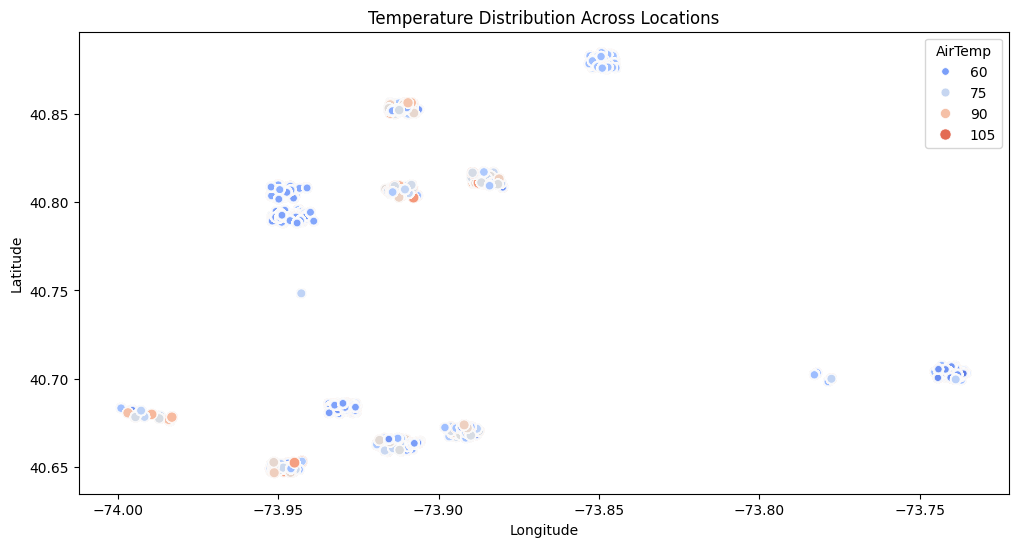

In [56]:
# Hottest and coolest locations in a neighborhood
location_variation = df.groupby(['ntacode', 'Sensor.ID'])['AirTemp'].agg(['mean', 'max', 'min']).reset_index()
print("Hottest and Coolest Locations within Each Neighborhood:")
print(location_variation.head())
    
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Longitude', y='Latitude', hue='AirTemp', size='AirTemp', data=df, palette='coolwarm')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Temperature Distribution Across Locations")
plt.show()

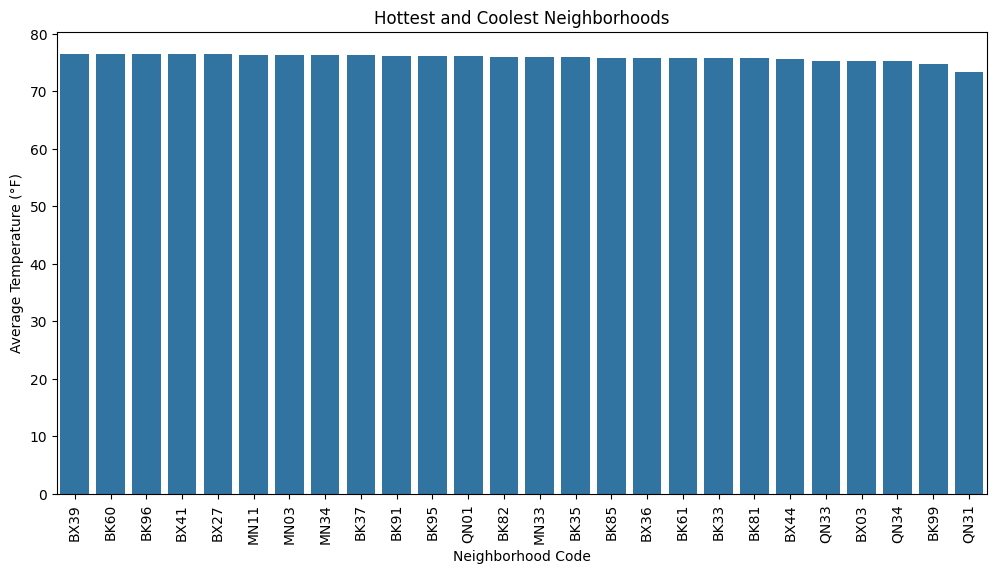

In [57]:
# Hottest and coolest neighborhoods overall
neighborhood_avg_temp = df.groupby('ntacode')['AirTemp'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=neighborhood_avg_temp.sort_values(by='AirTemp', ascending=False), x='ntacode', y='AirTemp')
plt.xticks(rotation=90)
plt.xlabel("Neighborhood Code")
plt.ylabel("Average Temperature (°F)")
plt.title("Hottest and Coolest Neighborhoods")
plt.show()

In [ ]:
#features = ['Hour', 'Latitude', 'Longitude', 'Year']
features = ['Datetime']
target = 'AirTemp'
    
df = df.dropna()
X = df[features]
y = df[target]
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
    
y_pred = model.predict(X_test)
    
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
    
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Temperature (°F)")
plt.ylabel("Predicted Temperature (°F)")
plt.title("Actual vs Predicted Temperature")
plt.show()

In [ ]:
df.set_index('Datetime', inplace=True)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y='AirTemp', hue='Borough', linewidth=1.5)

plt.xlabel("Time")
plt.ylabel("Temperature (°F)")
plt.title("Time Series Analysis of Temperature by Borough")
plt.legend(title="Borough")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# RNN Model for Time Series Forecasting
def build_rnn_model(df):
    df = df[['Datetime', 'AirTemp']].dropna()
    df.set_index('Datetime', inplace=True)
    scaler = MinMaxScaler()
    df['AirTemp'] = scaler.fit_transform(df[['AirTemp']])
    
    sequence_length = 24
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(df['AirTemp'].values[i:i+sequence_length])
        y.append(df['AirTemp'].values[i+sequence_length])
    
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))
    
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    plt.figure(figsize=(8, 5))
    plt.plot(y_test, label='Actual Temperature')
    plt.plot(y_pred, label='Predicted Temperature')
    plt.xlabel("Time")
    plt.ylabel("Temperature (°F)")
    plt.title("RNN Temperature Prediction")
    plt.legend()
    plt.show()